In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

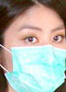

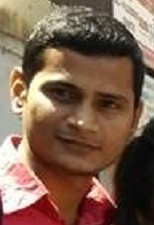

In [10]:
from PIL import Image
display(Image.open('./dataset/with_mask/0_0_0 copy 10.jpg'))
display(Image.open('./dataset/without_mask/1.jpg'))

In [13]:
train_data = datasets.ImageFolder('./dataset',transform=train_transform)
test_data = datasets.ImageFolder('./dataset',transform=test_transform)

In [29]:
# To tymczasowo, mozliwe ze nie wszystko bedzie potrzebne

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
np.random.seed(10)
class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train_idx
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [27]:
len(train_idx)

3094

In [28]:
len(test_idx)

773